In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# 读取用户上传的数据文件
file_path = "/Users/yaoyuyang/Desktop/📖校园学习/毕业论文/数据/【日度201912】Foreign_Exchange_Rates.csv"
df = pd.read_csv(file_path)

df['Time Serie'] = pd.to_datetime(df['Time Serie'])
df = df.sort_values('Time Serie')



In [20]:
# 数据转换为数值类型
selected_columns = df.loc[:, df.columns != 'Time Serie']
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')
df.update(selected_columns)

# 处理缺失值
df = df.replace("ND", np.nan).bfill().ffill()

# 提取人民币兑美元的汇率数据
yuan_df = df[['Time Serie', 'CHINA - YUAN/US$']].copy()
yuan_df.rename(columns={'CHINA - YUAN/US$': 'US$/YUAN'}, inplace=True)

# 归一化数据
scaler = MinMaxScaler()
yuan_df['US$/YUAN'] = scaler.fit_transform(yuan_df[['US$/YUAN']])



In [21]:
# 生成时间序列特征
def create_features(data, past_days=60, future_days=15):
    X, y = [], []
    for i in range(len(data) - past_days - future_days):
        X.append(data[i:i + past_days])
        y.append(data[i + past_days:i + past_days + future_days])
    return np.array(X), np.array(y)



In [22]:
# 分割数据
train_size = 4700
test_size = 517
X, y = create_features(yuan_df['US$/YUAN'].values)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size + test_size], y[train_size:train_size + test_size]



In [23]:
# 训练XGBoost模型
model = XGBRegressor(n_estimators=500, learning_rate=0.05, objective='reg:squarederror')
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# 预测检验集的未来15天的汇率
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)



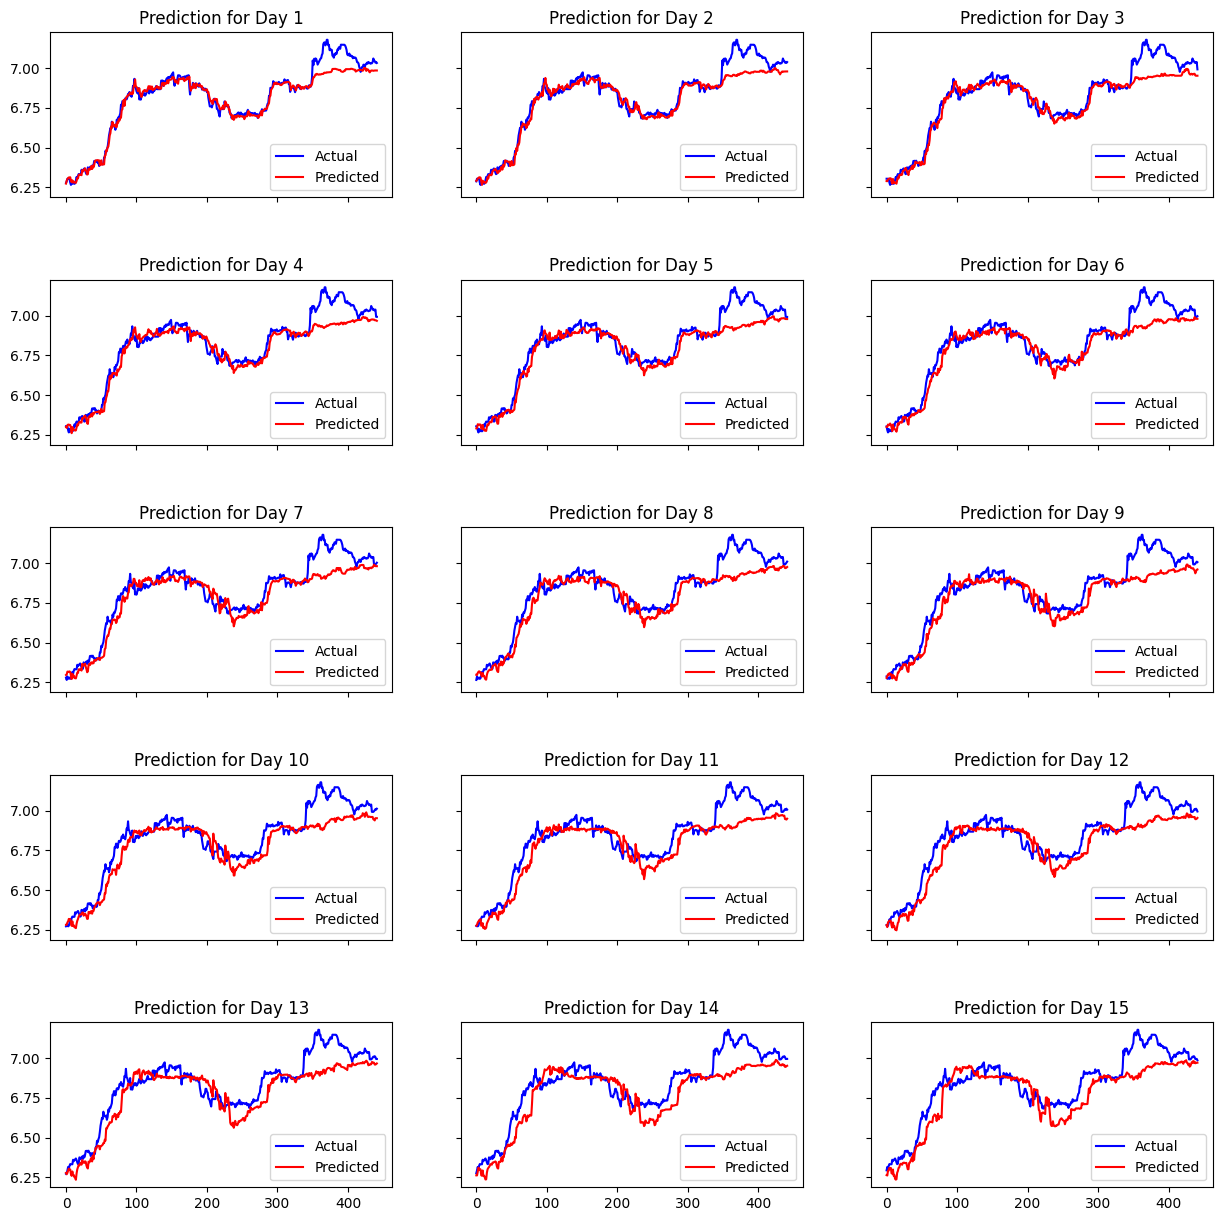

In [33]:
# 可视化每个未来15天预测的结果
fig, axs = plt.subplots(5, 3, sharex='all', sharey='all', figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for i in range(15):
    axs[i//3, i%3].plot(y_test[:, i], label='Actual', color='b')
    axs[i//3, i%3].plot(y_pred[:, i], label='Predicted', color='r')
    axs[i//3, i%3].title.set_text(f"Prediction for Day {i+1}")
    axs[i//3, i%3].legend()

plt.show()



In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
# 计算预测误差
print("Prediction MSE for ALL:", mean_squared_error(y_test, y_pred))
for i in range(15):
    print(f"Prediction MSE for Day {i+1}:", mean_squared_error(y_test[:, i], y_pred[:, i]))


Prediction MSE for ALL: 0.006916968134322657
Prediction MSE for Day 1: 0.0027346289420466614
Prediction MSE for Day 2: 0.0034873945722562107
Prediction MSE for Day 3: 0.004654135282087115
Prediction MSE for Day 4: 0.004932239571840507
Prediction MSE for Day 5: 0.005521782577110828
Prediction MSE for Day 6: 0.005212274498544741
Prediction MSE for Day 7: 0.006227189624067765
Prediction MSE for Day 8: 0.007051195209385692
Prediction MSE for Day 9: 0.00781839564756828
Prediction MSE for Day 10: 0.008103359377851104
Prediction MSE for Day 11: 0.008634122658616426
Prediction MSE for Day 12: 0.008781048309617073
Prediction MSE for Day 13: 0.009511713661782325
Prediction MSE for Day 14: 0.010506288077070412
Prediction MSE for Day 15: 0.01057875400499471


In [31]:
print("Prediction MAE for ALL:", mean_absolute_error(y_test, y_pred))
for i in range(15):
    print(f"Prediction MAE for Day {i+1}:", mean_absolute_error(y_test[:, i], y_pred[:, i]))

Prediction MAE for ALL: 0.060463676879215396
Prediction MAE for Day 1: 0.032066658114955425
Prediction MAE for Day 2: 0.03829272511857668
Prediction MAE for Day 3: 0.04602777098228493
Prediction MAE for Day 4: 0.04859977138053242
Prediction MAE for Day 5: 0.05177558594267834
Prediction MAE for Day 6: 0.05237236808500682
Prediction MAE for Day 7: 0.057602287972566814
Prediction MAE for Day 8: 0.06164380565833184
Prediction MAE for Day 9: 0.06578612357782564
Prediction MAE for Day 10: 0.06826628306462217
Prediction MAE for Day 11: 0.07139635657055886
Prediction MAE for Day 12: 0.07279511460696954
Prediction MAE for Day 13: 0.0765210713710181
Prediction MAE for Day 14: 0.08170614481792193
Prediction MAE for Day 15: 0.08210308592438162


In [32]:
print("Prediction R2 for ALL:", r2_score(y_test, y_pred))
for i in range(15):
    print(f"Prediction R2 for Day {i+1}:", r2_score(y_test[:, i], y_pred[:, i]))

Prediction R2 for ALL: 0.8417704308921411
Prediction R2 for Day 1: 0.9437829883388342
Prediction R2 for Day 2: 0.9275130007101197
Prediction R2 for Day 3: 0.9021272584637864
Prediction R2 for Day 4: 0.8951230870050769
Prediction R2 for Day 5: 0.8812509523863966
Prediction R2 for Day 6: 0.88661357695088
Prediction R2 for Day 7: 0.8629470600203382
Prediction R2 for Day 8: 0.8427727544145613
Prediction R2 for Day 9: 0.823168808202653
Prediction R2 for Day 10: 0.8142926929658991
Prediction R2 for Day 11: 0.7992463721646272
Prediction R2 for Day 12: 0.7927748251519515
Prediction R2 for Day 13: 0.7721638694955676
Prediction R2 for Day 14: 0.744348414792094
Prediction R2 for Day 15: 0.7384308023193293
